# Computer Vision

## Task 1

Давай загрузим датасет CIFAR-10. Допиши функцию [load_dataloaders](./code-samples/cv_utils.py) с помощью [torchvision.datasets.CIFAR10](https://pytorch.org/vision/main/generated/torchvision.datasets.CIFAR10.html)
и [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader), чтобы функция возвращала
DataLoaderы для train и test частей датасета. \
C помощью функции `len` количество батчей в train_loader и test_loader.
> Для DataLoader параметры `transform` и `batch_size` оставьте по умолчанию.

In [9]:
import torch
import numpy as np
from torch import *
import torchvision
from torchvision.transforms import transforms
from torchvision.datasets import CIFAR10
BASE_TRANSFORM = transforms.Compose(
    [
        # Перевод изображений в тензоры
        transforms.ToTensor(),
        # Переводим цвета пикселей в отрезок [-1, 1]
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)
BATCH_SIZE = 64 # Количество изображений в Батче
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') # Классы CIFAR10

In [10]:
def load_dataloaders(transform=BASE_TRANSFORM, batch_size=BATCH_SIZE):
    train_set = torchvision.datasets.CIFAR10(root='./cifar-10-batches-py', train=True, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

    test_set = torchvision.datasets.CIFAR10(root='./cifar-10-batches-py', train = False, transform = transform)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=2)

    return train_loader, test_loader
train_loader, test_loader = load_dataloaders()
print("The number of batches in a test_loader is: ", len(test_loader))

print("The number of batches in a train_loader is: ", len(train_loader))


Files already downloaded and verified
The number of batches in a test_loader is:  157
The number of batches in a train_loader is:  782


## Task 2

Узнай, как из объекта DataLoader можно получить изображения и метки. \
Передай первые 4 изображения и метки из первого батча тестовой выборки в функцию [imshow](./code-samples/cv_utils.py).
С помощью нее можно визуализировать датасет. \
Должна получиться примерно такая визуализация.
![sample](../misc/images/images_sample.png)
> Картинки и метки могут отличаться. Главное чтобы метки сходились с изображениями)

In [11]:
def imshow(images, labels, padding_size=15, labels_split_size=12):
    # убрать нормализацию
    images = images / 2 + 0.5
    npimg = images.numpy()
    label_text = (' ' * labels_split_size).join('{}'.format(CLASSES[j]) for j in labels.tolist())
    print(' ' * padding_size + label_text)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


               car            horse            deer            truck


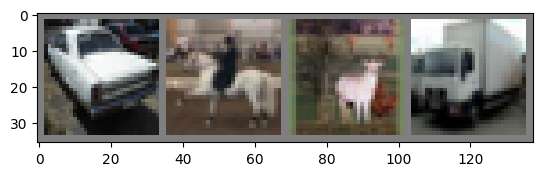

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# get some random training images

dataiter = iter(test_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[0:4]),(labels[0:4]))


## Task 3

Теперь попробуем написать небольшую сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Напишем сеть, основанную на одном блоке архитектуры [ResNet](https://arxiv.org/pdf/1512.03385.pdf) - Residual-Block. Схема этого блока приведена ниже:

<img src="../misc/images/rediual_block.png" width="500"/>

Допишите класс ResidualNet:
- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Также в сверточных слоях `padding = 1`

Функции, которые вам понадобяться:
[Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), [BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html), [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html).

Для базовой проверки, что сеть написана верно этот код не должен выдавать ошибку\
`assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)`

In [13]:
import torch.nn as nn
class ResidualNet(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()

        self.conv_3 = nn.Conv2d(3, 32, 1)

        self.residual_block = nn.Sequential(
            nn.Conv2d(3,32,kernel_size = 3,padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32,32,kernel_size = 3,padding = 1),
            nn.BatchNorm2d(32)

        )

        self.clf = nn.Sequential(
            nn.ReLU(),
            nn.AvgPool2d(8),
            nn.Flatten(1),
            nn.Linear(512, n_classes)
        )

    def forward(self, x):

        out = self.residual_block(x)
        out += self.conv_3(x)
        out = self.clf(out)

        return out

In [14]:
net = ResidualNet()

assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

## Task 4

Перейдем к обучению сети. В этом вам поможет класс [Trainer](./code-samples/cv_utils.py).\
Для обучения кроме самой модели
требуемся определить оптимизатор и функцию ошибок:
* В качестве оптимизатора выберите [стохастический градиентный спуск](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)
* В качестве функции ошибок
[кросс-энтропия](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

Обучите сеть и с помощью функции [plot_train_log](./code-samples/cv_utils.py) визуализируй процесс обучения модели.

In [15]:
class Trainer:

    def __init__(self, model, optimizer, criterion):
        self.model = model
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.model = self.model.to(self.device)
        print('Сеть загружена на', self.device)

        self.optimizer = optimizer
        self.criterion = criterion

    def _train_epoch(self, train_loader):
        loss_log = []
        acc_log = []
        self.model.train()

        for data, target in train_loader:
            data = data.to(self.device)
            target = target.to(self.device)

            self.optimizer.zero_grad()
            logits = self.model(data)

            loss = self.criterion(logits, target)
            loss.backward()
            self.optimizer.step()

            loss_log.append(loss.item() * data.shape[0])

            acc = (logits.argmax(dim=1) == target).sum()
            acc_log.append(acc.item() / data.shape[0])

        return np.mean(loss_log), np.mean(acc_log)

    def train(self, train_loader, test_loader, n_epochs):

        self.train_loss_log = []
        self.train_acc_log = []
        self.test_loss_log = []
        self.test_acc_log = []

        for epoch in range(1,n_epochs):
            train_loss, train_acc = self._train_epoch(train_loader)
            test_loss, test_acc = self.test(test_loader)

            self.train_loss_log.append(train_loss)
            self.train_acc_log.append(train_acc)

            self.test_loss_log.append(test_loss)
            self.test_acc_log.append(test_acc)

            print(f"Epoch {epoch}")
            print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
            print(f" test loss: {test_loss}, test acc: {test_acc}\n")

    def test(self, test_loader):
        loss_log = []
        acc_log = []
        self.model.eval()

        for data, target in test_loader:
            data = data.to(self.device)
            target = target.to(self.device)

            with torch.no_grad():
                logits = self.model(data)
                loss = self.criterion(logits, target)

            loss_log.append(loss.item() * data.shape[0])

            acc = (logits.argmax(dim=1) == target).sum()
            acc_log.append(acc.item() / data.shape[0])

        return np.mean(loss_log), np.mean(acc_log)

In [16]:
def plot_train_log(trainer):
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))

    axs[0].plot(range(1, len(trainer.train_loss_log) ), trainer.train_loss_log, label='train')
    axs[0].plot(range(1, len(trainer.test_loss_log) ), trainer.test_loss_log, label='test')
    axs[0].set_ylabel('Loss')

    axs[1].plot(range(1, len(trainer.train_acc_log) ), trainer.train_acc_log, label='train')
    axs[1].plot(range(1, len(trainer.test_acc_log) ), trainer.test_acc_log, label='test')
    axs[1].set_ylabel('Accuracy')

    for ax in axs:
        ax.set_xlabel('Epoch')
        ax.legend()

    plt.show()

In [17]:
model = ResidualNet()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()
trainer = Trainer(model, optimizer, loss_fn)
trainer._train_epoch(train_loader)
trainer.test(test_loader)
trainer.train(train_loader, test_loader, 6)

Сеть загружена на cuda:0


<ipython-input-15-46bf27eea26a>:42: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  for epoch in range(1,n_epochs):


Epoch 1.0
 train loss: 73.58798400215481, train acc: 0.5929507672634271
 test loss: 73.66192924596702, test acc: 0.5925557324840764

Epoch 2.0
 train loss: 65.70574998245824, train acc: 0.6401254795396419
 test loss: 65.95327236394213, test acc: 0.6378383757961783

Epoch 3.0
 train loss: 61.49854556861741, train acc: 0.6648617327365729
 test loss: 61.22255506333272, test acc: 0.6660031847133758

Epoch 4.0
 train loss: 58.79269255396655, train acc: 0.6796075767263428
 test loss: 60.482105151862854, test acc: 0.6725716560509554

Epoch 5.0
 train loss: 56.738136434189194, train acc: 0.6922554347826086
 test loss: 57.86389726286481, test acc: 0.6861066878980892

Epoch 6.0
 train loss: 55.06322578396029, train acc: 0.7028252877237852
 test loss: 56.012103584921284, test acc: 0.6932722929936306



<ipython-input-16-f07d0da01c30>:4: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  axs[0].plot(range(1, len(trainer.train_loss_log) ), trainer.train_loss_log, label='train')
<ipython-input-16-f07d0da01c30>:5: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  axs[0].plot(range(1, len(trainer.test_loss_log) ), trainer.test_loss_log, label='test')
<ipython-input-16-f07d0da01c30>:8: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  axs[1].plot(range(1, len(trainer.train_acc_log) ), trainer.train_acc_log, lab

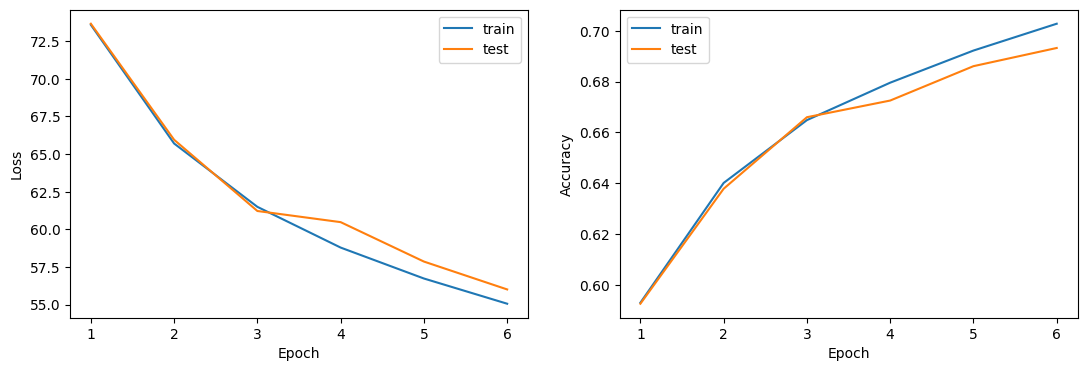

In [18]:
plot_train_log(trainer)

## Task 5


Одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. \
Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки,  тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.
Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке `transforms`, который затем передается в Dataloader.\
Изучи, какие [способы аугментаций](https://pytorch.org/vision/main/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py)
изображений можно использовать PyTorch. Выберите несколько из них и визуализируйте как изменился датасет.
![sample](../misc/images/images_sample.png)
![sample](../misc/images/augment.png)

Обучите сеть с аугментацией данных и с помощью функции [plot_train_log](./code-samples/cv_utils.py) визуализируй процесс обучения модели.

In [19]:

transform_v2 = transforms.Compose(
        [
            #transforms.CenterCrop(10),
            #transforms.Resize(205),
            transforms.GaussianBlur(1),
            transforms.RandomGrayscale(p=0.05),
            transforms.RandomRotation(degrees = 3),
            transforms.RandomInvert(p=0.1),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]
)#каждое изображение с какой-то долей вероятности (p) поворачивается, сжимается, обрезается, меняет цвета и яркость

Files already downloaded and verified
               car            horse            deer            truck


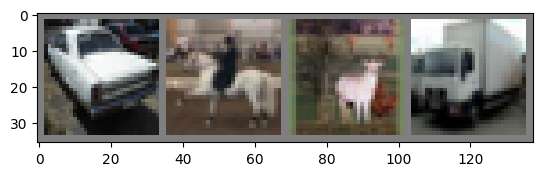

               cat            plane            frog            horse


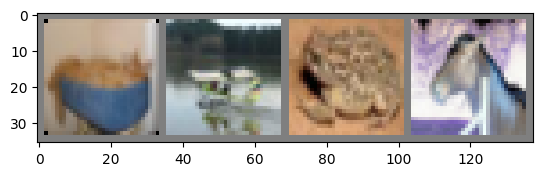

In [20]:
train_loader_v2, test_loader_v2 = load_dataloaders(transform=transform_v2, batch_size=BATCH_SIZE)
imshow(torchvision.utils.make_grid(images[0:4]),(labels[0:4]))
dataiter_v2 = iter(test_loader_v2)
images_v2, labels_v2 = next(dataiter_v2)
imshow(torchvision.utils.make_grid(images_v2[0:4]),(labels_v2[0:4]))

In [21]:
model_v2 = ResidualNet()
optimizer = torch.optim.SGD(model_v2.parameters(), lr=0.01, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()
trainer_v2 = Trainer(model_v2, optimizer, loss_fn)

Сеть загружена на cuda:0


In [22]:
trainer_v2.train(train_loader_v2, test_loader_v2, 10)

<ipython-input-15-46bf27eea26a>:42: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  for epoch in range(1,n_epochs):


Epoch 1.0
 train loss: 100.77836155464583, train acc: 0.43933823529411764
 test loss: 88.64025351651915, test acc: 0.5065684713375797

Epoch 2.0
 train loss: 81.2022373767765, train acc: 0.5524096867007673
 test loss: 75.70407190748081, test acc: 0.5801154458598726

Epoch 3.0
 train loss: 73.14045638745398, train acc: 0.6033407928388747
 test loss: 72.0630478950063, test acc: 0.609375

Epoch 4.0
 train loss: 68.97178908809067, train acc: 0.6250399616368286
 test loss: 66.15062040584102, test acc: 0.6434116242038217

Epoch 5.0
 train loss: 66.05157833392053, train acc: 0.6419437340153452
 test loss: 68.40212012855869, test acc: 0.6283837579617835

Epoch 6.0
 train loss: 63.93915567617587, train acc: 0.6548713235294118
 test loss: 64.80258266181703, test acc: 0.6480891719745223

Epoch 7.0
 train loss: 62.26030629126312, train acc: 0.6645820012787724
 test loss: 63.91230628141172, test acc: 0.6609275477707006

Epoch 8.0
 train loss: 60.77357914624616, train acc: 0.6715952685421995
 test l

<ipython-input-16-f07d0da01c30>:4: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  axs[0].plot(range(1, len(trainer.train_loss_log) ), trainer.train_loss_log, label='train')
<ipython-input-16-f07d0da01c30>:5: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  axs[0].plot(range(1, len(trainer.test_loss_log) ), trainer.test_loss_log, label='test')
<ipython-input-16-f07d0da01c30>:8: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  axs[1].plot(range(1, len(trainer.train_acc_log) ), trainer.train_acc_log, lab

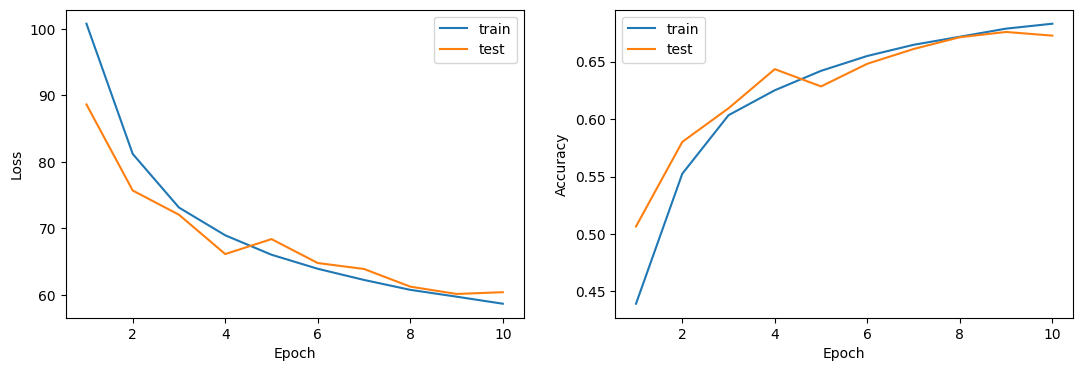

In [23]:
plot_train_log(trainer_v2)